In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import glob
import os

# --- CONFIGURATION ---
# On cherche les fichiers dans le dossier nfl-big-data-bowl-2026-prediction puis dans train/

INPUT_FILES = glob.glob("../nfl-big-data-bowl-2026-prediction/train/input_*.csv")
DATASET_FILE = '../nfl_dataset_v4_MULTI_AGENT.pt'
HISTORY_SIZE = 10 

# Normalisation
MAX_SPEED = 13.0
MAX_ACCEL = 10.0
MAX_DIST = 50.0

data_list = []

print(f"Génération du dataset : Multi-Agents (Tous les 'player_to_predict')...")

def get_angle_features(degree_val):
    rad = np.radians(degree_val)
    return np.sin(rad), np.cos(rad)

for in_file in INPUT_FILES:
    # Trouver le fichier output
    folder, filename = os.path.split(in_file)
    out_filename = filename.replace("input_", "output_")
    out_file = os.path.join(folder, out_filename)
    
    if not os.path.exists(out_file): continue
    
    df_in = pd.read_csv(in_file)
    df_out = pd.read_csv(out_file)
    
    common_plays = set(df_in['play_id']).intersection(df_out['play_id'])
    
    for play_id in tqdm(common_plays, leave=False, desc=filename):
        # Filtrer le play complet
        play_in = df_in[(df_in['game_id'] == df_in['game_id'].iloc[0]) & (df_in['play_id'] == play_id)].sort_values('frame_id')
        play_out = df_out[(df_out['game_id'] == df_out['game_id'].iloc[0]) & (df_out['play_id'] == play_id)].sort_values('frame_id')
        
        # On cherche TOUS les joueurs à prédire (pas juste le receveur visé)
        # On prend les IDs uniques qui sont marqués True à n'importe quel moment du play
        candidates = play_in[play_in['player_to_predict'] == True]['nfl_id'].unique()
        
        for target_id in candidates:
            # 1. Récupérer l'historique de CE joueur
            player_track = play_in[play_in['nfl_id'] == target_id]
            
            # S'il n'a pas assez d'historique (ex: vient de rentrer sur le terrain), on skip
            if len(player_track) < HISTORY_SIZE: continue
            
            # Séquence Input (les 10 dernières frames connues)
            history_seq = player_track.iloc[-HISTORY_SIZE:]
            current_pos = history_seq.iloc[-1]
            
            # 2. Récupérer son Futur (Label)
            future_track = play_out[play_out['nfl_id'] == target_id]
            if future_track.empty: continue # Pas de données futures dispos
            
            future_pos = future_track.iloc[-1]
            
            # Label = Offset (Déplacement relatif)
            label_x = (future_pos['x'] - current_pos['x'])
            label_y = (future_pos['y'] - current_pos['y'])
            label = torch.tensor([label_x, label_y], dtype=torch.float32)
            
            # --- CONSTRUCTION DES FEATURES ---
            
            # A. QUERY (Le joueur cible lui-même) : Séquence aplatie
            # Taille = 10 frames * 9 features = 90
            rec_features = []
            ball_x, ball_y = current_pos['ball_land_x'], current_pos['ball_land_y']
            
            for _, row in history_seq.iterrows():
                sin_d, cos_d = get_angle_features(row['dir'])
                sin_o, cos_o = get_angle_features(row['o'])
                
                # Est-ce que le joueur cible est en Attaque ?
                is_offense = 1.0 if play_in[play_in['nfl_id'] == target_id]['player_side'].iloc[0] == 'Offense' else 0.0

                feats = [
                    row['s'] / MAX_SPEED,
                    row['a'] / MAX_ACCEL,
                    sin_d, cos_d,
                    sin_o, cos_o,
                    (ball_x - row['x']) / MAX_DIST,
                    (ball_y - row['y']) / MAX_DIST,
                    is_offense
                ]
                rec_features.extend(feats)
            
            query = torch.tensor(rec_features, dtype=torch.float32)

            # B. KEYS (Le Contexte : TOUS les autres joueurs autour)
            # Important : On calcule la position relative par rapport au target_id actuel
            current_frame_id = current_pos['frame_id']
            
            # On prend tout le monde SAUF le joueur cible lui-même
            others = play_in[(play_in['frame_id'] == current_frame_id) & (play_in['nfl_id'] != target_id)]
            
            keys_list = []
            for _, other_row in others.iterrows():
                sin_d, cos_d = get_angle_features(other_row['dir'])
                sin_o, cos_o = get_angle_features(other_row['o'])
                
                # Est-ce un coéquipier ?
                # On compare le 'player_side' du voisin avec celui du target_id
                side_target = play_in[play_in['nfl_id'] == target_id]['player_side'].iloc[0]
                side_other = other_row['player_side']
                
                is_teammate = 1.0 if side_target == side_other else 0.0
                
                k_feats = [
                    (other_row['x'] - current_pos['x']) / MAX_DIST,
                    (other_row['y'] - current_pos['y']) / MAX_DIST,
                    other_row['s'] / MAX_SPEED,
                    other_row['a'] / MAX_ACCEL,
                    sin_d, cos_d,
                    sin_o, cos_o,
                    is_teammate # <--- NOUVELLE FEATURE
                ] 
                keys_list.append(k_feats)
            
            # Padding à 21 autres joueurs (11 def + 10 off max)
            # On augmente un peu la taille du padding pour être sûr
            while len(keys_list) < 22:
                keys_list.append([0.0] * 9)
                
            keys = torch.tensor(keys_list[:22], dtype=torch.float32) # (22, 9)

            data_list.append((query, keys, label))

            # 2. DATA AUGMENTATION : MIROIR VERTICAL (Flip Y)
            # L'axe Y va de 0 à 53.3. Inverser veut dire : y_new = 53.3 - y
            
            # Pour faire ça proprement sur les Tensors déjà créés :
            # Query (90 features) : [speed, accel, sin_d, cos_d, sin_o, cos_o, dist_x, dist_y] répété 10 fois
            # Inverser Y change le signe de : dist_y (feature 7) et cos_d/cos_o (composante verticale de l'angle)
            
            query_flip = query.clone()
            keys_flip = keys.clone()
            label_flip = label.clone()
            
            # Inverse la distance Y (Feature index 7, 15, 23... toutes les 8 features)
            # Note : Index 7 est dist_y. Index 3 est cos_d (direction Y). Index 5 est cos_o (orientation Y)
            
            # A. Inversion pour le Receveur (Query) - C'est une séquence aplatie
            # On inverse le signe de la composante Y (cosinus et distance Y)
            for i in range(10): # Pour les 10 frames
                base = i * 9
                query_flip[base + 3] *= -1 # Inverse Cos Direction (Y component)
                query_flip[base + 5] *= -1 # Inverse Cos Orientation (Y component)
                query_flip[base + 7] *= -1 # Inverse Dist Y
                
            # B. Inversion pour les Défenseurs (Keys) - (22, 9)
            # Features : [rel_x, rel_y, s, a, sin_d, cos_d, sin_o, cos_o]
            # Index à inverser : 1 (rel_y), 5 (cos_d), 7 (cos_o)
            keys_flip[:, 1] *= -1
            keys_flip[:, 5] *= -1
            keys_flip[:, 7] *= -1
            
            # C. Inversion du Label (x, y)
            label_flip[1] *= -1 # Inverse l'offset Y à prédire

            # Ajouter la version miroir
            data_list.append((query_flip, keys_flip, label_flip))

# Sauvegarde
print(f"Sauvegarde de {len(data_list)} exemples (Attaquants + Défenseurs)...")
if len(data_list) > 0:
    final_queries = torch.stack([x[0] for x in data_list])
    final_keys = torch.stack([x[1] for x in data_list])
    final_labels = torch.stack([x[2] for x in data_list])
    
    torch.save({'queries': final_queries, 'keys': final_keys, 'labels': final_labels}, DATASET_FILE)
    print(f"Dataset prêt : {DATASET_FILE}")
else:
    print("Aucun exemple généré.")

Génération du dataset : Multi-Agents (Tous les 'player_to_predict')...


Sauvegarde de 6324 exemples (Attaquants + Défenseurs)...
Dataset prêt : ../nfl_dataset_v4_MULTI_AGENT.pt


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NFLAttentionModel(nn.Module):
    def __init__(self, receiver_dim=90, defender_dim=9, embed_dim=128, num_heads=4):
        super().__init__()
        
        self.receiver_embedding = nn.Linear(receiver_dim, embed_dim)
        self.defender_embedding = nn.Linear(defender_dim, embed_dim)
        self.dropout = nn.Dropout(0.2) # 20% de chances d'oublier (régularisation)
        
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, receiver_data, defenders_data):
        # receiver_data: (Batch, 90)
        # defenders_data: (Batch, 22, 9)
        
        query = self.receiver_embedding(receiver_data).unsqueeze(1)
        keys = self.defender_embedding(defenders_data)
        values = keys 
        
        attn_output, attn_weights = self.attention(query, keys, values)
        x = self.dropout(attn_output.squeeze(1)) # Appliquer le dropout après l'attention
        prediction = self.regressor(x)
        return prediction, attn_weights

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 1. Classe Dataset Intelligente (Normalisation)
class NFLDataset(Dataset):
    def __init__(self, pt_file):
        print(f"Chargement du dataset : {pt_file} ...")
        data = torch.load(pt_file)
        
        self.queries = data['queries']
        self.keys = data['keys']
        self.labels = data['labels']
        
        # Vérification des dimensions pour être sûr
        print(f"    Chargé {len(self.labels)} exemples.")
        print(f"   - Query Shape : {self.queries.shape} (Doit être N, 90)")
        print(f"   - Keys Shape  : {self.keys.shape}   (Doit être N, 22, 9)")
        print(f"   - Labels Shape: {self.labels.shape} (Doit être N, 2)")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # On clone juste les tenseurs. 
        # AUCUN CALCUL ICI car tout est déjà fait dans la génération V4.
        q = self.queries[idx].clone()
        k = self.keys[idx].clone()
        y = self.labels[idx].clone()

        return q, k, y

Chargement du dataset : ../nfl_dataset_v4_MULTI_AGENT.pt ...
    Chargé 6324 exemples.
   - Query Shape : torch.Size([6324, 90]) (Doit être N, 90)
   - Keys Shape  : torch.Size([6324, 22, 9])   (Doit être N, 22, 9)
   - Labels Shape: torch.Size([6324, 2]) (Doit être N, 2)
Dataset Total : 6324
Train set : 5059 (pour apprendre)
Val set   : 1265 (pour évaluer)
Entraînement...
Epoch [1/1000] | Train Loss: 23.0493 | Val Loss: 17.3848
Epoch [2/1000] | Train Loss: 11.4776 | Val Loss: 9.1529
Epoch [3/1000] | Train Loss: 9.0072 | Val Loss: 8.2713
Epoch [4/1000] | Train Loss: 8.4812 | Val Loss: 8.0497
Epoch [5/1000] | Train Loss: 8.1757 | Val Loss: 7.9040
Epoch [6/1000] | Train Loss: 7.8524 | Val Loss: 7.6684
Epoch [7/1000] | Train Loss: 7.7749 | Val Loss: 8.0913
Epoch [8/1000] | Train Loss: 7.6432 | Val Loss: 7.6241
Epoch [9/1000] | Train Loss: 7.3653 | Val Loss: 7.7693
Epoch [10/1000] | Train Loss: 7.3187 | Val Loss: 7.2180
Epoch [11/1000] | Train Loss: 7.0911 | Val Loss: 7.0157
Epoch [12/1000

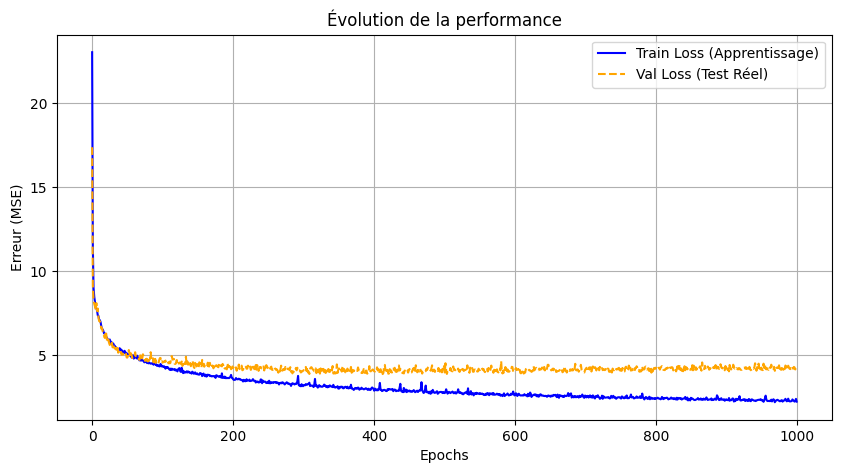

<Figure size 640x480 with 0 Axes>

In [19]:
# 2. Chargement
from torch.utils.data import random_split

# 1. Charger le dataset complet comme avant
full_dataset = NFLDataset('../nfl_dataset_v4_MULTI_AGENT.pt')

# 2. Calculer les tailles (80% Train, 20% Val)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# 3. Diviser le dataset aléatoirement
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

print(f"Dataset Total : {total_size}")
print(f"Train set : {len(train_subset)} (pour apprendre)")
print(f"Val set   : {len(val_subset)} (pour évaluer)")

# 4. Créer les DataLoaders distincts
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


# 3. Modèle (Assure-toi d'avoir la classe NFLAttentionModel définie)
# embed_dim=128 donne plus de capacité
# Mise à jour du modèle pour accepter les drapeaux d'équipe
model = NFLAttentionModel(
    receiver_dim=90,  # 9 features * 10 frames (au lieu de 80)
    defender_dim=9,   # 8 features + 1 flag ami/ennemi (au lieu de 8)
    embed_dim=64,
    num_heads=2
)

optimizer = optim.Adam(model.parameters(), lr=0.0005) # Learning rate plus doux
criterion = nn.MSELoss()
num_epochs = 1000 # Plus d'époques pour mieux converger

# 4. Entraînement
print("Entraînement...")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- PHASE 1 : ENTRAÎNEMENT (Sur les 80%) ---
    model.train() # Mode entraînement (active le dropout, etc.)
    running_loss = 0.0
    
    for queries, keys, labels in train_loader:
        optimizer.zero_grad()
        outputs, attention_weights = model(queries, keys)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- PHASE 2 : ÉVALUATION (Sur les 20%) ---
    model.eval() # Mode évaluation (fige le modèle)
    running_val_loss = 0.0
    
    with torch.no_grad(): # Désactive le calcul des gradients (économise la mémoire)
        for queries, keys, labels in val_loader:
            outputs, attention_weights = model(queries, keys)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Entraînement terminé !")

# Petit bonus : Visualiser les courbes pour vérifier le sur-apprentissage (Overfitting)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (Apprentissage)', color='blue')
plt.plot(val_losses, label='Val Loss (Test Réel)', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Erreur (MSE)')
plt.legend()
plt.title('Évolution de la performance')
plt.grid(True)
plt.show()
plt.savefig('../results/training_validation_loss.png')

In [7]:
#Sauvegarde du modèle entraîné
torch.save(model.state_dict(), '../models/nfl_attention_model_multi_agent.pth')

In [39]:
item = next(iter(train_loader))
print(item)

[tensor([[ 0.0130,  0.2516,  0.3590, -0.2224],
        [ 0.5430,  0.1310,  0.5108,  0.5896],
        [ 0.5880,  0.2881,  0.7884, -0.4368],
        [ 0.3260,  0.2892,  0.7354,  0.1906],
        [ 0.0220,  0.2471,  0.2406,  0.2398],
        [ 0.2250,  0.4214,  0.1760,  0.2120],
        [ 0.0220,  0.3269,  0.3204, -0.0848],
        [ 0.0610,  0.2489,  0.3350,  0.0610],
        [ 0.2360,  0.2267,  0.6256,  0.0262],
        [ 0.1270,  0.2814,  0.4074,  0.0504],
        [ 0.2990,  0.2415,  0.4244,  0.3134],
        [ 0.0970,  0.2350,  0.9118, -0.1216],
        [ 0.0600,  0.5109,  0.2298, -0.2678],
        [ 0.3430,  0.2355,  0.5754,  0.2108],
        [ 0.2510,  0.2077,  0.3916, -0.2096],
        [ 0.2720,  0.0383,  0.3900,  0.3810],
        [ 0.0320,  0.2792,  0.8154, -0.1930],
        [ 0.1610,  0.3035,  0.2482, -0.2038],
        [ 0.5820,  0.2621,  0.6494,  0.1504],
        [ 0.2400,  0.3127,  0.4378, -0.3486],
        [ 0.0000,  0.8587,  0.8226,  0.0908],
        [ 0.0000,  0.2760,  0.278

##EXEMPLE DE VISUALISATION D'UN PLAY COMPLET (INPUT + OUTPUT) AVEC MATPLOTLIB##

C:\Users\Shadow\AppData\Local\Temp\ipykernel_18936\1028941719.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_in['type'] = 'input'


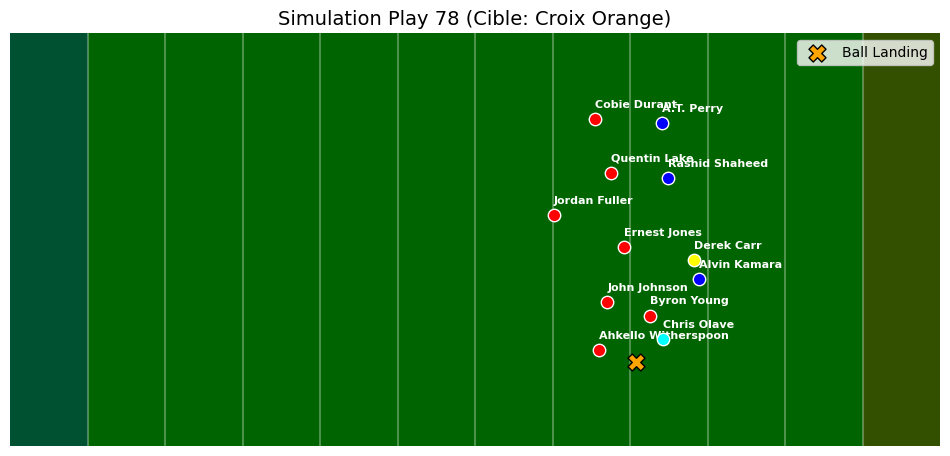

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

# 1. CHARGEMENT ET FILTRAGE DU FICHIER
# Assurez-vous que le fichier est dans le même dossier
df = pd.read_csv('nfl-big-data-bowl-2026-prediction/train/input_2023_w16.csv')
df_out = pd.read_csv('nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv')

# Choix du play à simuler (Ex: Match 2023122100, Play 78)
game_id_choisi = 2023122100
play_id_choisi = 78

play_in = df[(df['game_id'] == game_id_choisi) & (df['play_id'] == play_id_choisi)]
play_out = df_out[(df_out['game_id'] == game_id_choisi) & (df_out['play_id'] == play_id_choisi)].copy()

max_input_frame = play_in['frame_id'].max()
play_out['frame_id'] = play_out['frame_id'] + max_input_frame

cols_to_merge = ['nfl_id', 'player_name', 'player_role', 'player_side', 'player_position']
player_meta = play_in[cols_to_merge].drop_duplicates()
play_out = play_out.merge(player_meta, on='nfl_id', how='left')

# Création du dataset complet combiné
# On ajoute une colonne 'type' pour distinguer input/output visuellement si besoin
play_in['type'] = 'input'
play_out['type'] = 'output'
full_play = pd.concat([play_in, play_out], ignore_index=True)

# Récupération de la cible (Output)
target_x = full_play['ball_land_x'].iloc[0]
target_y = full_play['ball_land_y'].iloc[0]

# --- FONCTION DE DESSIN DU TERRAIN ---
def create_football_field(ax):
    # Fond vert
    ax.set_facecolor('darkgreen')
    ax.add_patch(patches.Rectangle((0, 0), 120, 53.3, facecolor='darkgreen', zorder=0))

    # Lignes (tous les 10 yards)
    for x in range(10, 111, 10):
        ax.axvline(x, color='white', linestyle='-', alpha=0.3)

    # Endzones (0-10 et 110-120)
    ax.add_patch(patches.Rectangle((0, 0), 10, 53.3, facecolor='blue', alpha=0.2))
    ax.add_patch(patches.Rectangle((110, 0), 10, 53.3, facecolor='red', alpha=0.2))

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_aspect('equal')
    ax.axis('off')

# --- CONFIGURATION DE L'ANIMATION ---
fig, ax = plt.subplots(figsize=(12, 6))
create_football_field(ax)
ax.set_title(f"Simulation Play {play_id_choisi} (Cible: Croix Orange)", color='black', fontsize=14)

# Marquer la zone de chute du ballon (Output)
ax.scatter(target_x, target_y, marker='X', s=150, color='orange', edgecolors='black', label='Ball Landing', zorder=2)

# Initialisation des points pour les joueurs
scatters = {}
# On sépare par rôles pour les couleurs
roles_colors = {
    'Passer': 'yellow',
    'Targeted Receiver': 'cyan',
    'Defensive Coverage': 'red',
    'Other Route Runner': 'blue' # Ou autres rôles offensifs
}

groups = full_play.groupby('nfl_id')
player_plots = {}

for nfl_id, group in groups:
    role = group['player_role'].iloc[0]
    side = group['player_side'].iloc[0]

    # Couleur par défaut : Rouge (Defense) ou Bleu (Offense)
    color = 'red' if side == 'Defense' else 'blue'

    # Couleurs spéciales pour les rôles clés
    if role in roles_colors:
        color = roles_colors[role]

    # Créer le point (scatter) et le texte (nom)
    scat = ax.scatter([], [], color=color, s=80, edgecolors='white', zorder=5)
    text = ax.text(0, 0, '', color='white', fontsize=8, fontweight='bold')
    player_plots[nfl_id] = (scat, text, group)

# Fonction de mise à jour image par image
def update(frame_num):
    # frame_num commence à 0, mais vos frame_id commencent souvent à 1
    current_frame_id = frame_num + 1

    for nfl_id, (scat, text, group) in player_plots.items():
        # Trouver la ligne correspondant à cette frame
        data = group[group['frame_id'] == current_frame_id]

        if not data.empty:
            x = data['x'].values[0]
            y = data['y'].values[0]
            name = data['player_name'].values[0]

            scat.set_offsets([[x, y]])
            text.set_position((x, y + 1.5)) # Texte un peu au dessus
            text.set_text(name)
        else:
            # Si pas de donnée pour ce joueur à cette frame (ex: sortie du champ)
            scat.set_offsets([[-10, -10]]) # Hors champ
            text.set_text('')

    return [p[0] for p in player_plots.values()] + [p[1] for p in player_plots.values()]

# Création de l'animation
frames_total = full_play['frame_id'].max()
ani = animation.FuncAnimation(fig, update, frames=frames_total, interval=100, blit=False)

plt.legend(loc='upper right')

# Pour sauvegarder en vidéo :
ani.save('simulation_nfl.gif', writer='pillow', fps=2)

##VISUALISATION D'UN PLAY QUI S'EST PASSE VS LA PREDICTION DU MODELE##

In [10]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from matplotlib.lines import Line2D

# --- CONSTANTES (Doivent être identiques à l'entraînement) ---
HISTORY_SIZE = 10
MAX_SPEED = 13.0
MAX_ACCEL = 10.0
MAX_DIST = 50.0

def get_angle_features(degree_val):
    rad = np.radians(degree_val)
    return np.sin(rad), np.cos(rad)

# --- 1. FONCTION DE PRÉPARATION V4 (Cruciale) ---
def prepare_input_v4(df, game_id, play_id, target_nfl_id):
    """
    Prépare les inputs complexes (Historique 10 frames + Physique + Drapeaux)
    pour un joueur spécifique.
    """
    # Filtrer le play complet
    play_data = df[(df['game_id'] == game_id) & (df['play_id'] == play_id)].sort_values('frame_id')
    
    # 1. Récupérer l'historique du joueur cible
    player_track = play_data[play_data['nfl_id'] == target_nfl_id]
    
    # Vérification : a-t-on assez d'historique ?
    if len(player_track) < HISTORY_SIZE:
        return None, None, None
        
    # Séquence Input (les 10 dernières frames)
    history_seq = player_track.iloc[-HISTORY_SIZE:]
    current_pos = history_seq.iloc[-1] # La dernière frame (T)
    
    # --- A. CONSTRUCTION DU RECEIVER (QUERY) ---
    # Taille attendue : 90 (10 frames * 9 features)
    rec_features = []
    ball_x, ball_y = current_pos['ball_land_x'], current_pos['ball_land_y']
    
    # Est-ce un attaquant ?
    is_offense = 1.0 if current_pos['player_side'] == 'Offense' else 0.0
    
    for _, row in history_seq.iterrows():
        sin_d, cos_d = get_angle_features(row['dir'])
        sin_o, cos_o = get_angle_features(row['o'])
        
        feats = [
            row['s'] / MAX_SPEED,
            row['a'] / MAX_ACCEL,
            sin_d, cos_d,
            sin_o, cos_o,
            (ball_x - row['x']) / MAX_DIST,
            (ball_y - row['y']) / MAX_DIST,
            is_offense # Feature 9 : Ami ou Ennemi (pour soi-même)
        ]
        rec_features.extend(feats)
        
    query = torch.tensor(rec_features, dtype=torch.float32).unsqueeze(0) # (1, 90)

    # --- B. CONSTRUCTION DES DÉFENSEURS/PARTENAIRES (KEYS) ---
    # On prend le contexte à la dernière frame connue
    current_frame_id = current_pos['frame_id']
    others = play_data[(play_data['frame_id'] == current_frame_id) & (play_data['nfl_id'] != target_nfl_id)]
    
    keys_list = []
    side_target = current_pos['player_side']
    
    for _, other_row in others.iterrows():
        sin_d, cos_d = get_angle_features(other_row['dir'])
        sin_o, cos_o = get_angle_features(other_row['o'])
        
        # Feature "Coéquipier"
        is_teammate = 1.0 if other_row['player_side'] == side_target else 0.0
        
        k_feats = [
            (other_row['x'] - current_pos['x']) / MAX_DIST, # Relatif à moi
            (other_row['y'] - current_pos['y']) / MAX_DIST,
            other_row['s'] / MAX_SPEED,
            other_row['a'] / MAX_ACCEL,
            sin_d, cos_d,
            sin_o, cos_o,
            is_teammate # Feature 9
        ]
        keys_list.append(k_feats)
    
    # Padding à 22 (taille max contexte)
    while len(keys_list) < 22:
        keys_list.append([0.0] * 9) # 9 zéros
        
    keys = torch.tensor(keys_list[:22], dtype=torch.float32).unsqueeze(0) # (1, 22, 9)
    
    # Position de départ pour l'affichage (Absolue)
    start_pos = (current_pos['x'], current_pos['y'])
    
    return query, keys, start_pos

# --- 2. FONCTION D'ANIMATION FINALE ---
def animate_prediction_v4(model, df_in, df_out, game_id, play_id):
    
    print(f"🔍 Visualisation V4 | Game {game_id} Play {play_id}")
    play_in = df_in[(df_in['game_id'] == game_id) & (df_in['play_id'] == play_id)]
    play_out_full = df_out[(df_out['game_id'] == game_id) & (df_out['play_id'] == play_id)]
    
    if play_in.empty: return print("❌ Erreur : Input vide.")

    # Ballon
    ball_x, ball_y = play_in['ball_land_x'].iloc[0], play_in['ball_land_y'].iloc[0]
    players_to_predict = play_out_full['nfl_id'].unique()
    
    # Couleurs
    player_colors = {}
    for nid in play_in['nfl_id'].unique():
        info = play_in[play_in['nfl_id'] == nid].iloc[0]
        side = info['player_side']
        if nid in players_to_predict:
            player_colors[nid] = '#FFD700' if side == 'Offense' else '#FF00FF' # Gold / Magenta
        else:
            player_colors[nid] = '#1f77b4' if side == 'Offense' else '#d62728' # Bleu / Rouge

    # --- PRÉDICTIONS ---
    ai_trajectories = {} 
    real_trajectories = {} 
    model.eval()
    
    for nid in players_to_predict:
        # Réalité
        real_track = play_out_full[play_out_full['nfl_id'] == nid].sort_values('frame_id')
        real_trajectories[nid] = real_track
        
        # IA (Appel de la nouvelle fonction V4)
        query, keys, start_pos = prepare_input_v4(df_in, game_id, play_id, nid)
        
        if query is not None:
            with torch.no_grad():
                pred, _ = model(query, keys)
            
            # Dénormalisation : Ici on suppose que le label était un Offset brut (Yards)
            # Si vous aviez divisé le label par 50, faites : pred[0,0].item() * 50.0
            dx = pred[0, 0].item() 
            dy = pred[0, 1].item()
            
            pred_x = start_pos[0] + dx
            pred_y = start_pos[1] + dy
            
            steps = len(real_track)
            if steps > 0:
                ai_xs = np.linspace(start_pos[0], pred_x, steps)
                ai_ys = np.linspace(start_pos[1], pred_y, steps)
                ai_trajectories[nid] = (ai_xs, ai_ys)

    # --- GRAPHIQUE ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_facecolor('#004d00')
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    for x in range(10, 111, 10): ax.axvline(x, color='white', alpha=0.15)
    
    # Ballon
    ball_marker = ax.scatter([ball_x], [ball_y], marker='X', s=200, c='white', edgecolors='black', zorder=20)
    
    # Légende
    legend_elements = [
        Line2D([0], [0], marker='X', color='w', markeredgecolor='k', label='Ballon'),
        Line2D([0], [0], color='#FFD700', lw=4, alpha=0.5, label='Vrai (Att)'),
        Line2D([0], [0], color='#FFD700', lw=2, linestyle='--', label='IA (Att)'),
        Line2D([0], [0], color='#FF00FF', lw=4, alpha=0.5, label='Vrai (Def)'),
        Line2D([0], [0], color='#FF00FF', lw=2, linestyle='--', label='IA (Def)'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', facecolor='black', labelcolor='white')

    # Objets
    scats = {}
    for nid in play_in['nfl_id'].unique():
        c = player_colors.get(nid, 'white')
        s = 120 if nid in players_to_predict else 40
        scats[nid] = ax.scatter([], [], s=s, c=c, edgecolors='white', zorder=10)
        
    lines_real = {nid: ax.plot([], [], c=player_colors[nid], alpha=0.4, lw=6, zorder=8)[0] for nid in players_to_predict}
    lines_ai = {nid: ax.plot([], [], c=player_colors[nid], ls='--', lw=2, marker='.', markersize=4, zorder=9)[0] for nid in players_to_predict}

    # Animation
    max_in_frame = int(play_in['frame_id'].max()) if not play_in.empty else 0
    max_out_steps = max([len(t) for t in real_trajectories.values()]) if real_trajectories else 10
    total_frames = int(max_in_frame + max_out_steps)

    def update(frame_idx):
        frame_num = frame_idx + 1
        title_text = f"Frame {frame_num} | INPUT" if frame_num <= max_in_frame else f"Step {frame_num - max_in_frame} | PRED vs REAL"
        ax.set_title(title_text, color='white', backgroundcolor='black')
        
        artists = [ball_marker]
        
        if frame_num <= max_in_frame:
            # Input
            current_data = play_in[play_in['frame_id'] == frame_num]
            for _, row in current_data.iterrows():
                nid = row['nfl_id']
                if nid in scats:
                    scats[nid].set_offsets([[row['x'], row['y']]])
                    artists.append(scats[nid])
        else:
            # Output
            step = frame_num - max_in_frame - 1
            for nid in players_to_predict:
                # Real
                if nid in real_trajectories and step < len(real_trajectories[nid]):
                    path = real_trajectories[nid]
                    lines_real[nid].set_data(path.iloc[:step+1]['x'], path.iloc[:step+1]['y'])
                    artists.append(lines_real[nid])
                    # Update point
                    pos = path.iloc[step]
                    scats[nid].set_offsets([[pos['x'], pos['y']]])
                    artists.append(scats[nid])
                # IA
                if nid in ai_trajectories and step < len(ai_trajectories[nid][0]):
                    xs, ys = ai_trajectories[nid]
                    lines_ai[nid].set_data(xs[:step+1], ys[:step+1])
                    artists.append(lines_ai[nid])
                    
        return artists
    # 1. Créer un dossier "results" s'il n'existe pas
    output_folder = "../results"
    # 2. Construire un nom unique basé sur l'ID du match et du jeu
    filename = f"pred_game_existing_{game_id}_play_{play_id}.html"
    filepath = os.path.join(output_folder, filename)

    ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=100, blit=True)
    with open(filepath, "w") as f:
        f.write(ani.to_jshtml())

    plt.close()
    return HTML(ani.to_jshtml())

In [11]:
import pandas as pd
import glob
import os

# Mettez le chemin vers votre dossier contenant les CSV
# Exemple : ""
path_to_train = "../nfl-big-data-bowl-2026-prediction/train/" 

def load_all_data(folder_path):
    # 1. Charger tous les inputs
    input_files = glob.glob(os.path.join(folder_path, "input_*.csv"))
    print(f"Fichiers Input trouvés : {len(input_files)}")
    df_in_list = [pd.read_csv(f) for f in input_files]
    if df_in_list:
        df_in_all = pd.concat(df_in_list, ignore_index=True)
    else:
        print("⚠️ Aucun fichier input trouvé !")
        return None, None

    # 2. Charger tous les outputs
    output_files = glob.glob(os.path.join(folder_path, "output_*.csv"))
    print(f"Fichiers Output trouvés : {len(output_files)}")
    df_out_list = [pd.read_csv(f) for f in output_files]
    if df_out_list:
        df_out_all = pd.concat(df_out_list, ignore_index=True)
    else:
        df_out_all = pd.DataFrame() # Vide

    return df_in_all, df_out_all

# Utilisation
df_in, df_out = load_all_data(path_to_train)
print(f"Dataset combiné : {len(df_in)} entrées d'input, {len(df_out)} entrées d'output.")

Fichiers Input trouvés : 18
Fichiers Output trouvés : 18
Dataset combiné : 4880579 entrées d'input, 562936 entrées d'output.


In [14]:
# Lancer la simulation
import random

# 1. Trouver les plays qui existent à la fois dans l'Input et l'Output
in_plays = set(zip(df_in['game_id'], df_in['play_id']))
out_plays = set(zip(df_out['game_id'], df_out['play_id']))
valid_plays = list(in_plays.intersection(out_plays))

if not valid_plays:
    print("Erreur : Aucun play commun trouvé entre df_in et df_out !")
else:
    # 2. Chercher un play intéressant (avec plusieurs joueurs à prédire si possible)
    chosen_game, chosen_play = None, None
    
    # On teste quelques plays au hasard pour en trouver un "multi-joueurs"
    random.shuffle(valid_plays)
    for g_id, p_id in valid_plays[:50]: # On regarde les 50 premiers mélangés
        # Vérifier combien de joueurs sont dans l'output
        out_data = df_out[(df_out['game_id'] == g_id) & (df_out['play_id'] == p_id)]
        unique_players = out_data['nfl_id'].nunique()
        
        if unique_players > 1:
            chosen_game, chosen_play = g_id, p_id
            print(f"Play Multi-Agents Trouvé : {unique_players} joueurs à prédire !")
            break
    
    # Si on n'en a pas trouvé avec >1, on prend le premier qui vient
    if chosen_game is None:
        chosen_game, chosen_play = valid_plays[0]
        print("Play simple trouvé (1 seul joueur à prédire).")

    print(f"Lancement de l'animation pour GameID={chosen_game}, PlayID={chosen_play}")

    # 3. Lancer la fonction avec ces IDs garantis valides
    video = animate_prediction_v4(model, df_in, df_out, chosen_game, chosen_play)
    display(video)

Play Multi-Agents Trouvé : 3 joueurs à prédire !
Lancement de l'animation pour GameID=2023100806, PlayID=1143
🔍 Visualisation V4 | Game 2023100806 Play 1143


In [15]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from matplotlib.lines import Line2D

# --- CONSTANTES ---
HISTORY_SIZE = 10
MAX_SPEED = 13.0
MAX_ACCEL = 10.0
MAX_DIST = 50.0

def get_angle_features(degree_val):
    rad = np.radians(degree_val)
    return np.sin(rad), np.cos(rad)

# --- 1. PRÉPARATION INPUT TEST (Sans Output) ---
def prepare_test_input(df, game_id, play_id, target_nfl_id):
    play_data = df[(df['game_id'] == game_id) & (df['play_id'] == play_id)].sort_values('frame_id')
    player_track = play_data[play_data['nfl_id'] == target_nfl_id]
    
    if len(player_track) < HISTORY_SIZE: return None, None, None, None
        
    # Input Sequence
    history_seq = player_track.iloc[-HISTORY_SIZE:]
    current_pos = history_seq.iloc[-1]
    
    # 1. Query (90 features)
    rec_features = []
    ball_x, ball_y = current_pos['ball_land_x'], current_pos['ball_land_y']
    is_offense = 1.0 if current_pos['player_side'] == 'Offense' else 0.0
    
    for _, row in history_seq.iterrows():
        sin_d, cos_d = get_angle_features(row['dir'])
        sin_o, cos_o = get_angle_features(row['o'])
        feats = [
            row['s'] / MAX_SPEED, row['a'] / MAX_ACCEL,
            sin_d, cos_d, sin_o, cos_o,
            (ball_x - row['x']) / MAX_DIST, (ball_y - row['y']) / MAX_DIST,
            is_offense
        ]
        rec_features.extend(feats)
    query = torch.tensor(rec_features, dtype=torch.float32).unsqueeze(0)

    # 2. Keys (Contexte)
    current_frame_id = current_pos['frame_id']
    others = play_data[(play_data['frame_id'] == current_frame_id) & (play_data['nfl_id'] != target_nfl_id)]
    keys_list = []
    side_target = current_pos['player_side']
    
    for _, other_row in others.iterrows():
        sin_d, cos_d = get_angle_features(other_row['dir'])
        sin_o, cos_o = get_angle_features(other_row['o'])
        is_teammate = 1.0 if other_row['player_side'] == side_target else 0.0
        k_feats = [
            (other_row['x'] - current_pos['x']) / MAX_DIST, (other_row['y'] - current_pos['y']) / MAX_DIST,
            other_row['s'] / MAX_SPEED, other_row['a'] / MAX_ACCEL,
            sin_d, cos_d, sin_o, cos_o, is_teammate
        ]
        keys_list.append(k_feats)
    
    while len(keys_list) < 22: keys_list.append([0.0] * 9)
    keys = torch.tensor(keys_list[:22], dtype=torch.float32).unsqueeze(0)
    
    start_pos = (current_pos['x'], current_pos['y'])
    # On récupère le nombre de frames à prédire (spécifique au test set)
    num_frames_out = int(current_pos['num_frames_output'])
    
    return query, keys, start_pos, num_frames_out

# --- 2. ANIMATION TEST ---
def animate_test_prediction(model, test_input_df, test_df, game_id, play_id):
    print(f"🎬 Visualisation TEST | Game {game_id} Play {play_id}")
    
    # Filtrer les inputs
    play_in = test_input_df[(test_input_df['game_id'] == game_id) & (test_input_df['play_id'] == play_id)]
    if play_in.empty: return print("❌ Input vide.")

    # Qui doit-on prédire ? (Depuis le fichier test.csv ou player_to_predict=True)
    # Option 1 : Utiliser test.csv si dispo
    targets_in_test_file = test_df[(test_df['game_id'] == game_id) & (test_df['play_id'] == play_id)]['nfl_id'].unique()
    # Option 2 : Fallback sur input
    targets_in_input = play_in[play_in['player_to_predict'] == True]['nfl_id'].unique()
    
    players_to_predict = targets_in_test_file if len(targets_in_test_file) > 0 else targets_in_input
    print(f"   -> {len(players_to_predict)} joueurs à prédire.")

    # Ballon
    ball_x, ball_y = play_in['ball_land_x'].iloc[0], play_in['ball_land_y'].iloc[0]

    # Couleurs
    player_colors = {}
    for nid in play_in['nfl_id'].unique():
        info = play_in[play_in['nfl_id'] == nid].iloc[0]
        side = info['player_side']
        if nid in players_to_predict:
            player_colors[nid] = '#FFD700' if side == 'Offense' else '#FF00FF' # Gold / Magenta
        else:
            player_colors[nid] = '#1f77b4' if side == 'Offense' else '#d62728' # Bleu / Rouge

    # --- PRÉDICTIONS ---
    ai_trajectories = {}
    model.eval()
    max_steps_pred = 0

    for nid in players_to_predict:
        query, keys, start_pos, n_frames = prepare_test_input(test_input_df, game_id, play_id, nid)
        
        if query is not None:
            with torch.no_grad():
                pred, _ = model(query, keys)
            
            # Dénormalisation (Offset brut prédit)
            # Attention : Le modèle a appris à prédire la position FINALE relative.
            # On va interpoler linéairement jusqu'à cette position.
            dx = pred[0, 0].item()
            dy = pred[0, 1].item()
            
            pred_x = start_pos[0] + dx
            pred_y = start_pos[1] + dy
            
            steps = n_frames # Le nombre de frames demandé par le test set
            max_steps_pred = max(max_steps_pred, steps)
            
            ai_xs = np.linspace(start_pos[0], pred_x, steps)
            ai_ys = np.linspace(start_pos[1], pred_y, steps)
            ai_trajectories[nid] = (ai_xs, ai_ys)

    # --- GRAPHIQUE ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_facecolor('#004d00')
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    for x in range(10, 111, 10): ax.axvline(x, color='white', alpha=0.15)
    
    # Ballon
    ball_marker = ax.scatter([ball_x], [ball_y], marker='X', s=200, c='white', edgecolors='black', zorder=20)
    
    # Légende
    legend_elements = [
        Line2D([0], [0], marker='X', color='w', markeredgecolor='k', label='Ballon (Cible)'),
        Line2D([0], [0], color='#FFD700', lw=2, linestyle='--', marker='.', label='IA (Attaque)'),
        Line2D([0], [0], color='#FF00FF', lw=2, linestyle='--', marker='.', label='IA (Défense)'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', facecolor='black', labelcolor='white')

    # Objets
    scats = {}
    for nid in play_in['nfl_id'].unique():
        c = player_colors.get(nid, 'white')
        s = 120 if nid in players_to_predict else 40
        scats[nid] = ax.scatter([], [], s=s, c=c, edgecolors='white', zorder=10)
        
    lines_ai = {nid: ax.plot([], [], c=player_colors[nid], ls='--', lw=2, marker='.', markersize=4, zorder=9)[0] for nid in players_to_predict}

    # Animation
    max_in_frame = int(play_in['frame_id'].max())
    total_frames = int(max_in_frame + max_steps_pred)

    def update(frame_idx):
        frame_num = frame_idx + 1
        title_text = f"TEST SET | Frame {frame_num}"
        ax.set_title(title_text, color='white', backgroundcolor='black')
        artists = [ball_marker]
        
        if frame_num <= max_in_frame:
            # Phase Input
            current_data = play_in[play_in['frame_id'] == frame_num]
            for _, row in current_data.iterrows():
                nid = row['nfl_id']
                if nid in scats:
                    scats[nid].set_offsets([[row['x'], row['y']]])
                    artists.append(scats[nid])
        else:
            # Phase Prediction
            step = frame_num - max_in_frame - 1
            for nid in players_to_predict:
                if nid in ai_trajectories:
                    xs, ys = ai_trajectories[nid]
                    if step < len(xs):
                        # Tracer la ligne progressive
                        lines_ai[nid].set_data(xs[:step+1], ys[:step+1])
                        artists.append(lines_ai[nid])
                        # Bouger le point au bout de la ligne
                        scats[nid].set_offsets([[xs[step], ys[step]]])
                        artists.append(scats[nid])
                    
        return artists

    # 1. Créer un dossier "results" s'il n'existe pas
    output_folder = "../results"
    # 2. Construire un nom unique basé sur l'ID du match et du jeu
    filename = f"pred_game_{game_id}_play_{play_id}.html"
    filepath = os.path.join(output_folder, filename)

    ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=100, blit=True)
    with open(filepath, "w") as f:
        f.write(ani.to_jshtml())

    plt.close()
    return HTML(ani.to_jshtml())

In [18]:
# --- EXEMPLE D'UTILISATION ---
# Chargez vos fichiers test
df_test_in = pd.read_csv('../nfl-big-data-bowl-2026-prediction/test_input.csv')
df_test = pd.read_csv('../nfl-big-data-bowl-2026-prediction/test.csv')

# Choisissez un play au hasard dans le test set
import random
random_play = df_test.sample(1).iloc[0]
g_id, p_id = random_play['game_id'], random_play['play_id']

# Lancez l'animation
animate_test_prediction(model, df_test_in, df_test, g_id, p_id)

🎬 Visualisation TEST | Game 2024120805 Play 1847
   -> 2 joueurs à prédire.
